# Confronto tra due gruppi {#sec-two-groups-comparison}

**Prerequisiti**

Leggi *Comparisons within randomised groups can be very misleading* [@bland2011comparisons] per comprendere come i metodi statistici debbano essere integrati con una profonda conoscenza dei disegni di ricerca.

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import statistics as stat
from scipy import stats
from cmdstanpy import cmdstan_path, CmdStanModel

# Configuration
seed = sum(map(ord, "stan_two_groups"))
rng = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"

# Print project directory to verify
print(f"Project directory: {project_directory}")

Project directory: /Users/corradocaudek/_repositories/psicometria


## Introduzione {.unnumbered}

L'obiettivo di questo capitolo è di ampliare la discussione del @sec-stan-one-mean, affrontando il confronto tra le medie di due gruppi indipendenti. 

## Stima bayesiana e test dell'ipotesi nulla

Spesso, ci troviamo ad affrontare la necessità di confrontare due gruppi di dati. Potrebbe interessarci sapere se la media di un gruppo è maggiore o diversa rispetto a quella di un altro gruppo. Per effettuare tale confronto, è fondamentale utilizzare un modello statistico, poiché le vere differenze tra i gruppi sono spesso accompagnate da rumore di misurazione o fluttuazioni casuali del fenomeno in esame. Questo rende difficile trarre conclusioni basandosi unicamente sulle differenze calcolate dai dati osservati.

Il metodo tradizionale per confrontare statisticamente due o più gruppi è quello di utilizzare un test statistico. Questo approccio prevede l'individuazione di un'ipotesi nulla, che solitamente afferma che non ci sono differenze tra i gruppi, e l'utilizzo di una statistica test per determinare se i dati osservati sono plausibili sotto questa ipotesi. L'ipotesi nulla viene rifiutata quando la statistica test calcolata supera una soglia predefinita.

Tuttavia, i test di ipotesi possono essere complessi e i risultati spesso soggetti a interpretazioni errate. La scelta delle specifiche del test statistico (ad esempio, quale test utilizzare, quale ipotesi nulla testare, quale livello di significatività adottare) è spesso arbitraria e basata su convenzioni piuttosto che sulla specificità del problema o delle decisioni da prendere (Johnson, 1999). Inoltre, i risultati forniti dai test sono spesso indiretti, incompleti e tendono a sovrastimare le evidenze contro l'ipotesi nulla (Goodman, 1999).

**Un approccio più informativo ed efficace per il confronto tra gruppi è quello basato sulla stima invece che sul test dell'ipotesi nulla**, ed è guidato dalla probabilità bayesiana anziché dalla frequentista. In pratica, invece di testare se ci sono differenze tra i gruppi, si cerca di ottenere una stima di quanto siano effettivamente diversi. Questo approccio è intrinsecamente più informativo. Inoltre, viene inclusa una stima dell'incertezza associata a tale differenza, che tiene conto sia dell'incertezza dovuta alla nostra mancanza di conoscenza dei parametri del modello (incertezza epistemica) sia dell'incertezza causata dalla variabilità intrinseca del sistema (incertezza aleatoria).

## Un esempio illustrativo

In questo esempio, l'obiettivo è stimare la differenza tra le medie del quoziente di intelligenza dei bambini di due gruppi distinti in base al livello di scolarità della madre. Il primo gruppo include i bambini la cui madre non ha completato le scuole superiori, mentre il secondo gruppo comprende quelli la cui madre ha ottenuto il diploma superiore. Per questo, useremo i dati `kidiq` e un modello bayesiano al fine di ottenere una stima affidabile della differenza tra le medie dei due gruppi nella popolazione.

I dati utilizzati sono forniti da Gelman e Hill (2007) e costituiscono un sottocampione estratto dal  *National Longitudinal Survey of Youth*.

Leggiamo i dati.

In [2]:
df = pd.read_stata("../../data/kidiq.dta")
df.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


Il dataset contiene le seguenti colonne:

- "kid_score": il quoziente intellettivo (QI) dei bambini. È una misura dell'intelligenza del bambino.
- "mom_hs": una variabile binaria che indica se la madre del bambino ha completato o meno la scuola superiore. Può assumere i valori 0 o 1, dove 0 rappresenta "no" (la madre non ha completato la scuola superiore) e 1 rappresenta "sì" (la madre ha completato la scuola superiore).

Ci sono 93 bambini la cui madre non ha completato la scuola superiore e 341 bambini la cui madre ha ottenuto il diploma di scuola superiore.

In [3]:
df.groupby(["mom_hs"]).size()

mom_hs
0.0     93
1.0    341
dtype: int64

Le statistiche descrittive si ottengono nel modo seguente.

In [4]:
df["kid_score"].mean()

86.79723502304148

In [4]:
summary_stats = [np.mean, stat.stdev]
df.groupby(["mom_hs"]).aggregate(summary_stats)

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_63722/1859022749.py:2: FutureWarning: The provided callable <function mean at 0x11c1f6660> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(["mom_hs"]).aggregate(summary_stats)


kid_score                 mom_iq             mom_work            \
             mean      stdev        mean      stdev      mean     stdev   
mom_hs                                                                    
0.0     77.548387  22.573800   91.889152  12.630498  2.322581  1.226175   
1.0     89.319648  19.049483  102.212049  14.848414  3.052786  1.120727   

          mom_age            
             mean     stdev  
mom_hs                       
0.0     21.677419  2.727323  
1.0     23.087977  2.617453

I bambini la cui madre ha completato le superiori tendono ad avere un QI maggiore di 11.8 punti rispetto ai bambini la cui madre non ha concluso le superiori.

In [105]:
89.319648 - 77.548387

11.771260999999996

Creiamo due vettori che contengono il QI dei bambini dei due gruppi.

In [5]:
# Vector of kid_score when mom_hs is 1
kid_score_mom_hs_1 = df[df["mom_hs"] == 1]["kid_score"]

# Vector of kid_score when mom_hs is 0
kid_score_mom_hs_0 = df[df["mom_hs"] == 0]["kid_score"]

## Dimensione dell'effetto 

Nel caso presente, la differenza tra le medie dei due gruppi è di 11.8 punti sulla scala del QI, e potrebbe sembrare un risultato rilevante, considerando che la metrica del QI è facilmente interpretabile. Tuttavia, è importante notare che il test utilizzato in questo studio non è il WISC, che ha una distribuzione normale con media 100 e deviazione standard 15, ma il test PIAT.

In generale, è difficile comprendere il significato di una differenza tra le medie di due gruppi quando viene presentata solo come valore assoluto, soprattutto quando le varianze dei gruppi sono diverse. Per ottenere una misura più informativa, è necessario considerare sia la differenza tra le medie dei gruppi che l'incertezza associata a queste stime delle medie della popolazione. L'indice statistico che soddisfa questo scopo è noto come "dimensione dell'effetto" (effect size).

La dimensione dell'effetto è una misura della forza dell'associazione osservata, che tiene conto sia della grandezza della differenza tra i gruppi attesi che dell'incertezza sui dati. Tra gli indici più comunemente utilizzati per quantificare la dimensione dell'effetto, vi è l'indice $d$ di Cohen. 

Nel caso di due medie, questo indice è dato da:

$$
d={\frac {{\bar {x}}_{1}-{\bar {x}}_{2}}{s}},
$$

laddove

$$
s={\sqrt {\frac {(n_{1}-1)s_{1}^{2}+(n_{2}-1)s_{2}^{2}}{n_{1}+n_{2}-2}}}
$$

e la varianza di ciascun gruppo è calcolata come

$$
s_{1}^{2}={\frac {1}{n_{1}-1}}\sum _{i=1}^{n_{1}}(x_{1,i}-{\bar {x}}_{1})^{2}.
$$

Solitamente, l'indice $d$ di Cohen si interpreta usando la metrica seguente:

| Dimensione dell'effetto |   $d$   |
| ----------------------- | ------- |
| Very small              | 0.01	|
| Small                   | 0.20	|
| Medim                   | 0.50	|
| Large                   | 0.80	|
| Very large              | 1.20	|
| Huge                    | 2.0     |

Per una trattazione bayesiana della stima della dimensione dell'effetto, si veda @doingbayesian.

## Modello bayesiano

Il modello bayesiano per il confronto tra le medie di due gruppi indipendenti comprende la definizione della verosimiglianza per i dati di ciascun gruppo e la descrizione delle distribuzioni a priori dei parametri rilevanti. Inoltre, in questo caso, abbiamo incluso anche la stima della dimensione dell'effetto, che ci permette di valutare la forza dell'associazione osservata tra i gruppi, tenendo conto dell'incertezza sui dati.

Creiamo un dizonario con i dati rilevanti.

In [6]:
stan_data = {
    'N1': len(kid_score_mom_hs_1), 
    'N2': len(kid_score_mom_hs_0), 
    'y1': kid_score_mom_hs_1,
    'y2': kid_score_mom_hs_0
}
stan_data

{'N1': 341,
 'N2': 93,
 'y1': 0       65
 1       98
 2       85
 3       83
 4      115
       ... 
 425    102
 426    104
 430     76
 432     88
 433     70
 Name: kid_score, Length: 341, dtype: int32,
 'y2': 5       98
 14     102
 19     101
 24      99
 33     106
       ... 
 422    100
 427     59
 428     93
 429     94
 431     50
 Name: kid_score, Length: 93, dtype: int32}

## Modello Stan

Per analizzare questi dati ci serviremo del seguente modello Stan.

In [7]:
stan_file = os.path.join(project_directory, 'stan', 'kid-score.stan')
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=0> N1;  // number of observations (group 1)
  int<lower=0> N2;  // number of observations (group 2)
  vector[N1] y1;  // response times (group 1)
  vector[N2] y2;  // response times (group 2)
}

parameters {
  real mu_1;  // mean of group 1
  real mu_2;  // mean of group 2
  real<lower=0> sigma_1;  // standard deviation of group 1
  real<lower=0> sigma_2;  // standard deviation of group 2
}

transformed parameters {
  real delta;  // difference in means
  real cohen_d;  // Cohen's d effect size
  delta = mu_1 - mu_2;
  cohen_d = delta / sqrt((sigma_1^2 + sigma_2^2) / 2);
}

model {
  // Priors
  mu_1 ~ normal(80, 20);  // Prior for mean of group 1
  mu_2 ~ normal(80, 20);  // Prior for mean of group 2
  sigma_1 ~ normal(0, 10);  // Prior for standard deviation of group 1
  sigma_2 ~ normal(0, 10);  // Prior for standard deviation of group 2

  // Likelihood
  y1 ~ normal(mu_1, sigma_1);
  y2 ~ normal(mu_2, sigma_2);
}

generated quantities {
  vector[N1] y1_rep;  // 

Nel nostro modello:
- `N1` è il numero di osservazioni nel primo gruppo (bambini le cui madri hanno completato le superiori)
- `N2` è il numero di osservazioni nel secondo gruppo (bambini le cui madri non hanno completato le superiori)
- `y1` è un vettore contenente i valori di QI per il primo gruppo
- `y2` è un vettore contenente i valori di QI per il secondo gruppo

### Spiegazione del modello

#### Parametri

- `mu_1` e `mu_2`: Rappresentano le medie dei valori di QI per i due gruppi.
- `sigma_1` e `sigma_2`: Rappresentano le deviazioni standard dei valori dei QI per i due gruppi.

#### Parametri trasformati

- `delta`: È la differenza tra le medie dei due gruppi (mu_1 - mu_2).
- `cohen_d`: È la dimensione dell'effetto di Cohen, che quantifica la differenza tra i gruppi in unità di deviazione standard.

#### Prior

Impostiamo delle prior per i parametri:

```
mu_1 ~ normal(80, 20);
mu_2 ~ normal(80, 20);
sigma_1 ~ normal(0, 10);
sigma_2 ~ normal(0, 10);
```
Queste prior riflettono le nostre conoscenze o supposizioni iniziali sui possibili valori di questi parametri. Per esempio, ci aspettiamo che i QI medi siano intorno a 80, ma con una certa variabilità.

#### Likelihood

```
y1 ~ normal(mu_1, sigma_1);
y2 ~ normal(mu_2, sigma_2);
```
Questa parte del modello descrive come i dati osservati (y1 e y2) sono generati, date le medie e le deviazioni standard per ciascun gruppo. Assumiamo che i valori del QI seguano una distribuzione normale in ciascun gruppo.

### Quantità generate

```
y1_rep[i] = normal_rng(mu_1, sigma_1);
y2_rep[i] = normal_rng(mu_2, sigma_2);
```
Queste righe generano dati "replicati" basati sul modello stimato. Questi possono essere utilizzati per il controllo del modello (posterior predictive checks).

### Interpretazione dei risultati

1. `mu_1` e `mu_2`: Ci dicono i valori QI medi stimati per ciascun gruppo.
2. `sigma_1` e `sigma_2`: Ci dicono quanto variano i valori del QI all'interno di ciascun gruppo.
3. `delta`: Ci dice quanto è grande la differenza nei valori dei QI medi tra i due gruppi.
4. `cohen_d`: Ci fornisce una misura standardizzata della dimensione dell'effetto.

### Conclusione

Questo modello ci permette di:

1. Stimare i valori dei QI medi e la loro variabilità per ciascun gruppo.
2. Quantificare la differenza tra i gruppi e la sua incertezza.
3. Calcolare una misura standardizzata della dimensione dell'effetto (Cohen's d).
4. Generare previsioni basate sul modello per future osservazioni.

Il vantaggio principale di questo approccio bayesiano è che otteniamo distribuzioni di probabilità complete per tutti i parametri di interesse, permettendoci di fare affermazioni probabilistiche sulla differenza tra i gruppi e sulla dimensione dell'effetto.

Eseguiamo il campionamento MCMC:

In [8]:
sample = model.sample(
    data=stan_data, seed=123, chains=4,
    iter_sampling=1000, iter_warmup=1000,
    show_progress=False, show_console=False
)

10:30:52 - cmdstanpy - INFO - CmdStan start processing
10:30:52 - cmdstanpy - INFO - Chain [1] start processing
10:30:52 - cmdstanpy - INFO - Chain [2] start processing
10:30:52 - cmdstanpy - INFO - Chain [3] start processing
10:30:52 - cmdstanpy - INFO - Chain [4] start processing
10:30:52 - cmdstanpy - INFO - Chain [1] done processing
10:30:52 - cmdstanpy - INFO - Chain [3] done processing
10:30:52 - cmdstanpy - INFO - Chain [2] done processing
10:30:52 - cmdstanpy - INFO - Chain [4] done processing
10:30:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'kid-score.stan', line 30, column 2 to column 29)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'kid-score.stan', line 30, column 2 to column 29)
Consider re-running with show_console=True if the above output is unclear!


Esaminiamo le tracce:

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_63722/1925110735.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


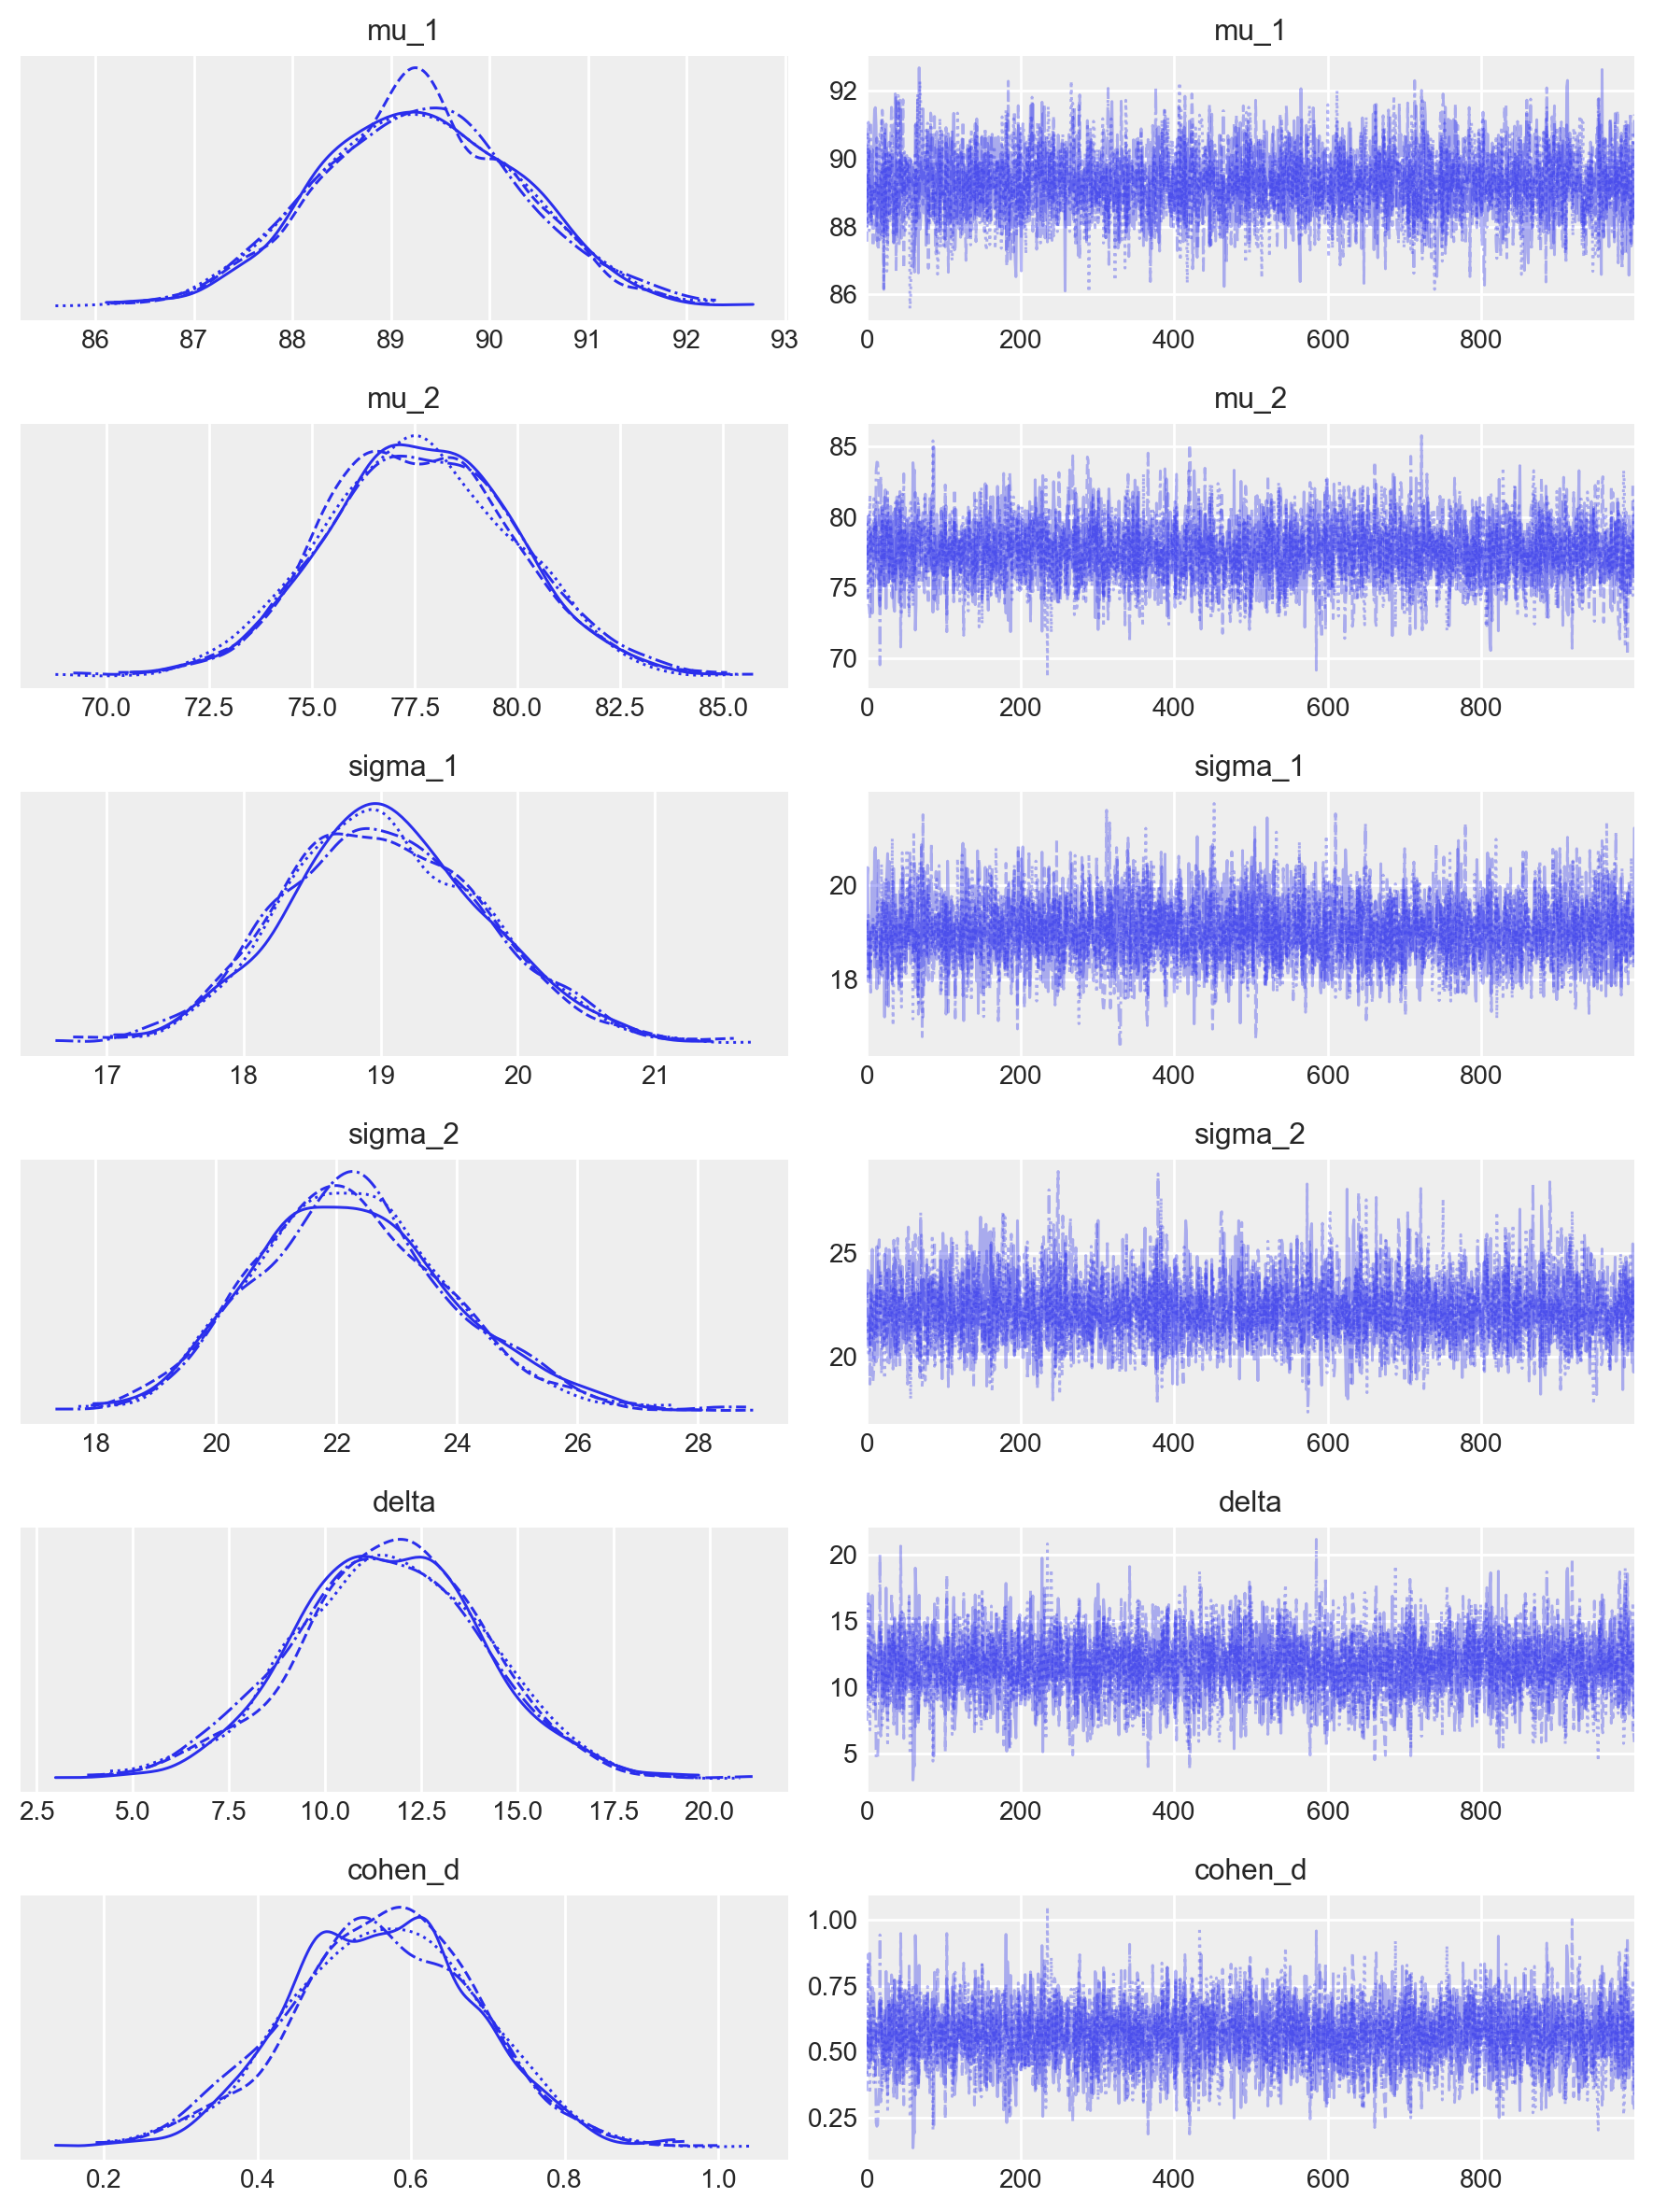

In [9]:
_ = az.plot_trace(
    sample, 
    figsize=(9, 12), 
    var_names=['mu_1', 'mu_2', 'sigma_1', 'sigma_2', 'delta', 'cohen_d'], 
    divergences="bottom"
)
plt.tight_layout()

Le distribuzioni predittive a posteriori sono adeguate, senza essere perfette.

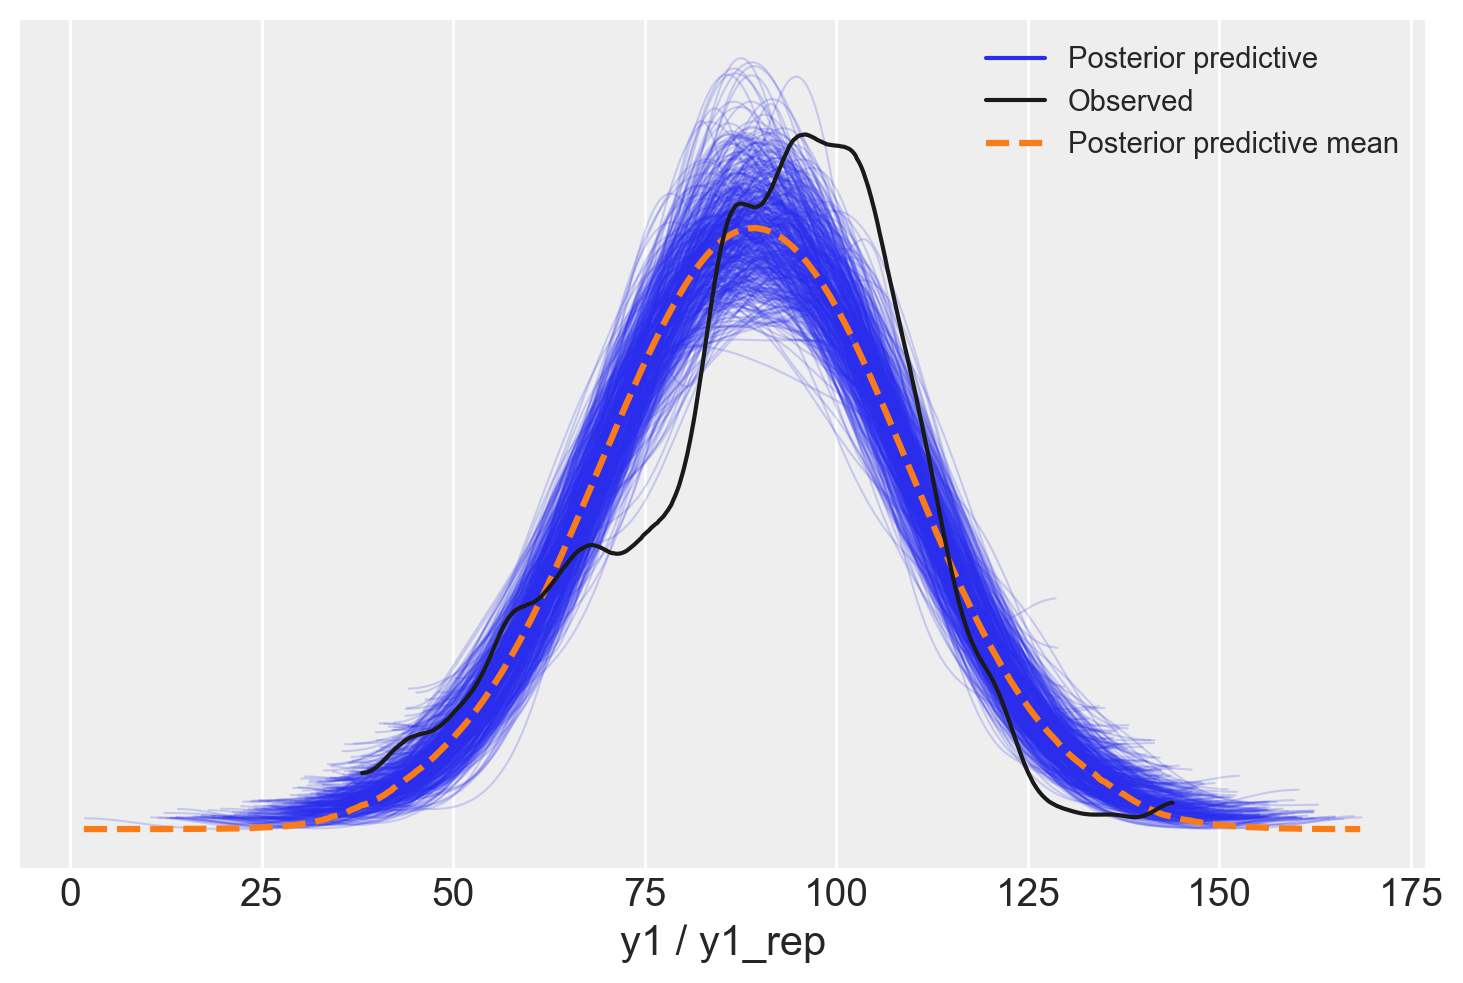

In [10]:
idata = az.from_cmdstanpy(
    posterior=sample, 
    posterior_predictive=['y1_rep'], 
    observed_data={"y1": stan_data["y1"]}
)
_ = az.plot_ppc(idata, data_pairs={"y1": "y1_rep"}, num_pp_samples=500)

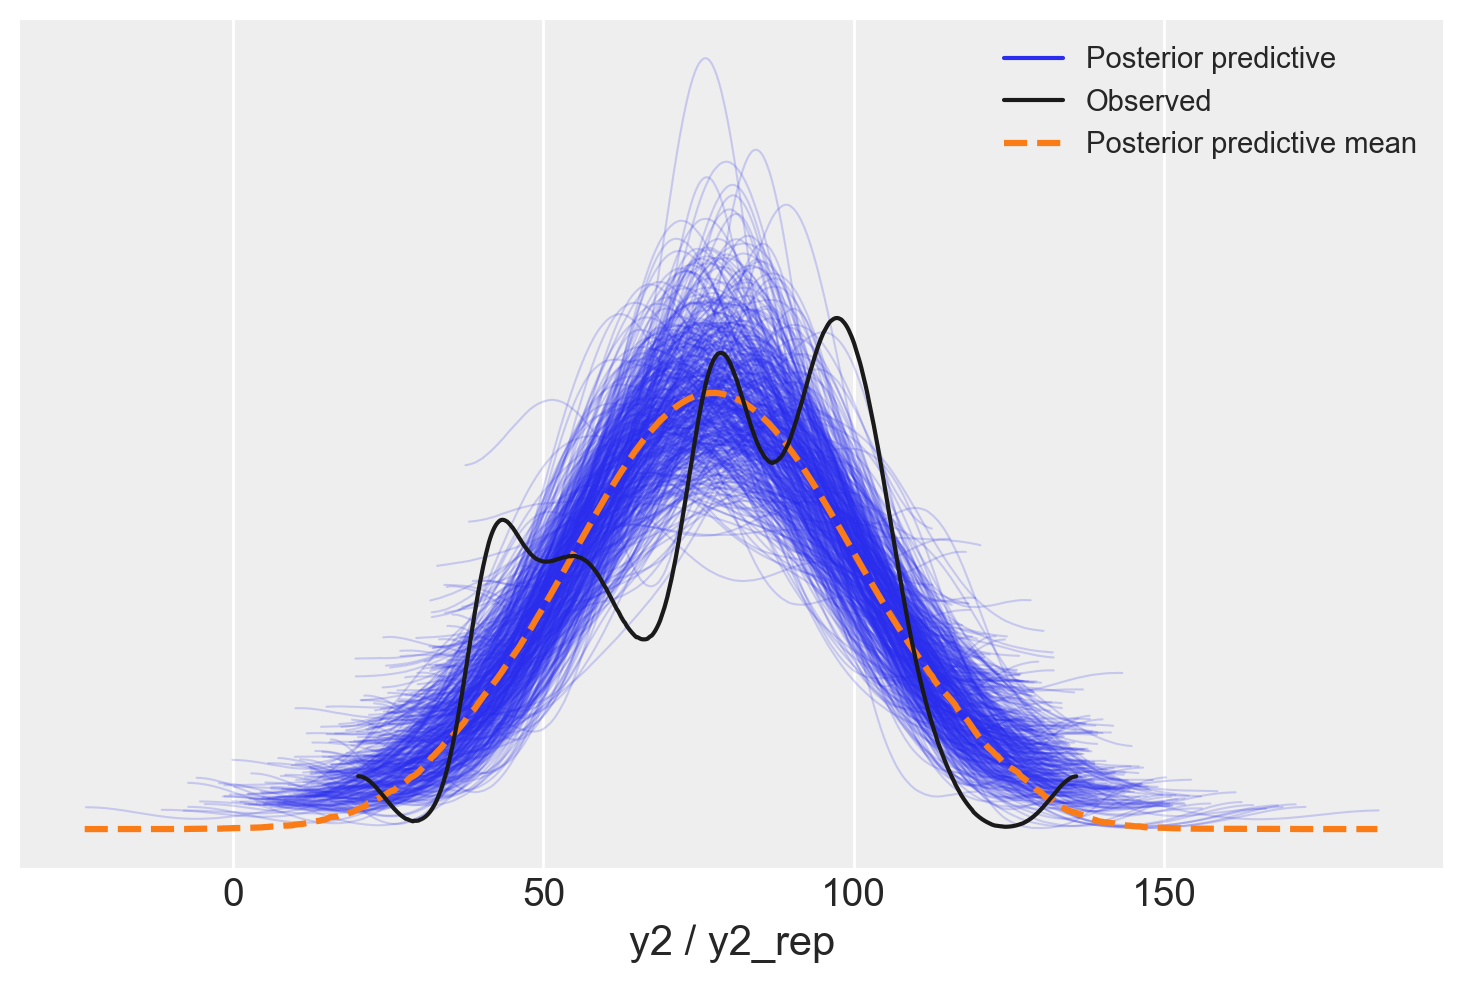

In [11]:
idata = az.from_cmdstanpy(
    posterior=sample, 
    posterior_predictive=['y2_rep'], 
    observed_data={"y2": stan_data["y2"]}
)
_ = az.plot_ppc(idata, data_pairs={"y2": "y2_rep"}, num_pp_samples=500)

Un sommario delle distribuzioni a posteriori dei parametri si ottiene nel modo seguente:

In [12]:
az.summary(
    sample, 
    var_names=['mu_1', 'mu_2', 'sigma_1', 'sigma_2', 'delta', 'cohen_d'], 
    round_to=2
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_1,89.28,1.04,87.33,91.18,0.02,0.01,3990.38,2947.67,1.0
mu_2,77.61,2.27,73.61,82.01,0.03,0.02,4317.58,2940.56,1.0
sigma_1,19.03,0.73,17.70,20.42,0.01,0.01,4729.21,3162.76,1.0
sigma_2,22.27,1.63,19.35,25.38,0.02,0.02,4419.97,2908.53,1.0
delta,11.67,2.47,6.89,16.32,0.04,0.03,4346.03,2887.27,1.0
cohen_d,0.56,0.12,0.33,0.78,0.00,0.00,4334.34,2953.62,1.0


## Modello Robusto

Un modello bayesiano robusto per il confronto tra due medie indipendenti può gestire deviazioni standard disuguali e outlier sostituendo la verosimiglianza normale con quella della distribuzione t di Student. Utilizzare una distribuzione t di Student al posto di una normale rende il modello più resistente agli outlier. La distribuzione t di Student ha code più pesanti rispetto alla normale, il che significa che è meno influenzata da valori estremi nei dati. Questo è particolarmente utile quando si sospetta la presenza di outlier nei dati o quando le deviazioni standard tra i gruppi sono disuguali. In questo modo, il modello bayesiano robusto offre stime più affidabili delle medie e delle deviazioni standard dei gruppi, nonché della differenza tra le medie e della dimensione dell'effetto.

In [13]:
stan_file_t = os.path.join(project_directory, 'stan', 'kid-score-t.stan')
model_t = CmdStanModel(stan_file=stan_file_t)
print(model_t.code())

data {
  int<lower=0> N1;  // number of observations (group 1)
  int<lower=0> N2;  // number of observations (group 2)
  vector[N1] y1;  // response time (group 1)
  vector[N2] y2;  // response time (group 2)
}
parameters {
  real mu_2;  // mean of group 2
  real delta;  // difference in means
  real<lower=0> sigma_1;  // scale parameter for group 1
  real<lower=0> sigma_2;  // scale parameter for group 2
  real<lower=1> nu;  // degrees of freedom of student's t distribution
}
transformed parameters {
  real mu_1 = mu_2 + delta; 
}
model {
  y1 ~ student_t(nu, mu_1, sigma_1);
  y2 ~ student_t(nu, mu_2, sigma_2);
  // priors
  mu_2 ~ normal(80, 20);
  delta ~ normal(0, 10);
  sigma_1 ~ normal(0, 10);
  sigma_2 ~ normal(0, 10);
  nu ~ gamma(2, 0.1);
}
generated quantities {
  vector[N1] y1rep;
  vector[N2] y2rep;
  real pooled_sd = sqrt((sigma_1^2 + sigma_2^2) / 2);
  real cohen_d = delta / pooled_sd;
  
  for (i in 1:N1) {
    y1rep[i] = student_t_rng(nu, mu_1, sigma_1);
  }
  for (i in

In [14]:
sample_t = model_t.sample(
    data=stan_data, seed=123, chains=4,
    iter_sampling=1000, iter_warmup=1000,
    show_progress=False, show_console=False
)

10:31:20 - cmdstanpy - INFO - CmdStan start processing
10:31:20 - cmdstanpy - INFO - Chain [1] start processing
10:31:20 - cmdstanpy - INFO - Chain [2] start processing
10:31:20 - cmdstanpy - INFO - Chain [3] start processing
10:31:20 - cmdstanpy - INFO - Chain [4] start processing
10:31:20 - cmdstanpy - INFO - Chain [1] done processing
10:31:20 - cmdstanpy - INFO - Chain [3] done processing
10:31:20 - cmdstanpy - INFO - Chain [2] done processing
10:31:20 - cmdstanpy - INFO - Chain [4] done processing
10:31:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: student_t_lpdf: Scale parameter is 0, but must be positive finite! (in 'kid-score-t.stan', line 18, column 2 to column 36)
Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'kid-score-t.stan', line 18, column 2 to column 36)
Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'kid-score-t.stan', line 18, column 2 to column 36)
	Exception: student_t

Nel caso presente, usare un modello robusto non produce nessuna differenza rispetto al modello precedente in quanto non ci sono deviazoni importanti rispetto alla gaussianità e le due deviazioni standard sono simili.

In [15]:
az.summary(
    sample_t, 
    var_names=['mu_1', 'mu_2', 'sigma_1', 'sigma_2', 'delta', 'cohen_d'], 
    round_to=2
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_1,89.49,1.07,87.43,91.37,0.02,0.01,3892.59,3003.83,1.0
mu_2,78.39,2.29,74.04,82.63,0.05,0.03,2486.44,2273.07,1.0
sigma_1,18.43,0.77,17.04,19.94,0.01,0.01,3278.45,2545.50,1.0
sigma_2,21.71,1.62,18.77,24.82,0.03,0.02,3175.33,2299.83,1.0
delta,11.11,2.50,6.40,15.82,0.05,0.04,2487.74,2084.50,1.0
cohen_d,0.55,0.13,0.33,0.81,0.00,0.00,2496.90,2123.93,1.0


## Modello con Iper-priors

Il seguente modello bayesiano per il confronto tra due medie indipendenti utilizza una distribuzione di Student's t per gestire deviazioni standard disuguali e outlier. Inoltre, include iper-priors per una maggiore flessibilità nella definizione dei parametri delle distribuzioni a priori, che vengono stimate dai dati. Questo approccio permette di incorporare in modo più efficace le incertezze sui parametri dei priors stessi, migliorando la robustezza del modello.

In [16]:
stan_file_h = os.path.join(project_directory, 'stan', 'kid-score-h.stan')
model_h = CmdStanModel(stan_file=stan_file_h)
print(model_t.code())

data {
  int<lower=0> N1;  // number of observations (group 1)
  int<lower=0> N2;  // number of observations (group 2)
  vector[N1] y1;  // response time (group 1)
  vector[N2] y2;  // response time (group 2)
}
parameters {
  real mu_2;  // mean of group 2
  real delta;  // difference in means
  real<lower=0> sigma_1;  // scale parameter for group 1
  real<lower=0> sigma_2;  // scale parameter for group 2
  real<lower=1> nu;  // degrees of freedom of student's t distribution
}
transformed parameters {
  real mu_1 = mu_2 + delta; 
}
model {
  y1 ~ student_t(nu, mu_1, sigma_1);
  y2 ~ student_t(nu, mu_2, sigma_2);
  // priors
  mu_2 ~ normal(80, 20);
  delta ~ normal(0, 10);
  sigma_1 ~ normal(0, 10);
  sigma_2 ~ normal(0, 10);
  nu ~ gamma(2, 0.1);
}
generated quantities {
  vector[N1] y1rep;
  vector[N2] y2rep;
  real pooled_sd = sqrt((sigma_1^2 + sigma_2^2) / 2);
  real cohen_d = delta / pooled_sd;
  
  for (i in 1:N1) {
    y1rep[i] = student_t_rng(nu, mu_1, sigma_1);
  }
  for (i in

In [17]:
sample_h = model_h.sample(
    data=stan_data, seed=123, chains=4,
    iter_sampling=2_000, iter_warmup=1_000,
    show_progress=False, show_console=False
)

10:31:27 - cmdstanpy - INFO - CmdStan start processing
10:31:27 - cmdstanpy - INFO - Chain [1] start processing
10:31:27 - cmdstanpy - INFO - Chain [2] start processing
10:31:27 - cmdstanpy - INFO - Chain [3] start processing
10:31:27 - cmdstanpy - INFO - Chain [4] start processing
10:31:28 - cmdstanpy - INFO - Chain [1] done processing
10:31:28 - cmdstanpy - INFO - Chain [4] done processing
10:31:28 - cmdstanpy - INFO - Chain [2] done processing
10:31:28 - cmdstanpy - INFO - Chain [3] done processing
10:31:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: student_t_lpdf: Scale parameter is 0, but must be positive finite! (in 'kid-score-h.stan', line 43, column 2 to column 36)
	Exception: student_t_lpdf: Scale parameter is 0, but must be positive finite! (in 'kid-score-h.stan', line 43, column 2 to column 36)
Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'kid-score-h.stan', line 43, column 2 to column 36)
	Exception: student_t_

Anche in questo caso, la risposta non cambia:

In [18]:
az.summary(
    sample_h, 
    var_names=['mu_1', 'mu_2', 'sigma_1', 'sigma_2', 'delta', 'cohen_d'], 
    round_to=2
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_1,89.52,1.03,87.65,91.54,0.01,0.01,8653.78,6400.92,1.0
mu_2,78.30,2.29,73.95,82.52,0.03,0.02,5688.16,5777.55,1.0
sigma_1,18.43,0.79,16.97,19.94,0.01,0.01,7954.84,5392.71,1.0
sigma_2,21.88,1.65,18.88,25.08,0.02,0.01,9745.94,5250.42,1.0
delta,11.22,2.50,6.51,15.83,0.03,0.02,5590.51,6029.02,1.0
cohen_d,0.56,0.13,0.32,0.79,0.00,0.00,5626.06,5815.05,1.0


Il nostro obiettivo è comprendere se le medie dei due gruppi sono diverse, e l'incertezza associata alla stima a posteriori del parametro `delta` è fondamentale per rispondere a questa domanda. Se l'intervallo di credibilità associato a `delta` non include lo 0, allora possiamo concludere con un certo grado di sicurezza che le medie dei due gruppi sono diverse. In altre parole, se l'intervallo di credibilità non contiene lo 0, allora ci sono prove convincenti che le medie dei due gruppi sono diverse.

Nel caso presente, l'intervallo di credibilità al 94% non include lo 0. Pertanto, possiamo concludere, con un livello di sicurezza soggettivo del 94%, che il QI dei bambini le cui madri hanno completato le scuole superiori tende ad essere più elevato rispetto a quello dei bambini le cui madri non hanno completato le scuole superiori.

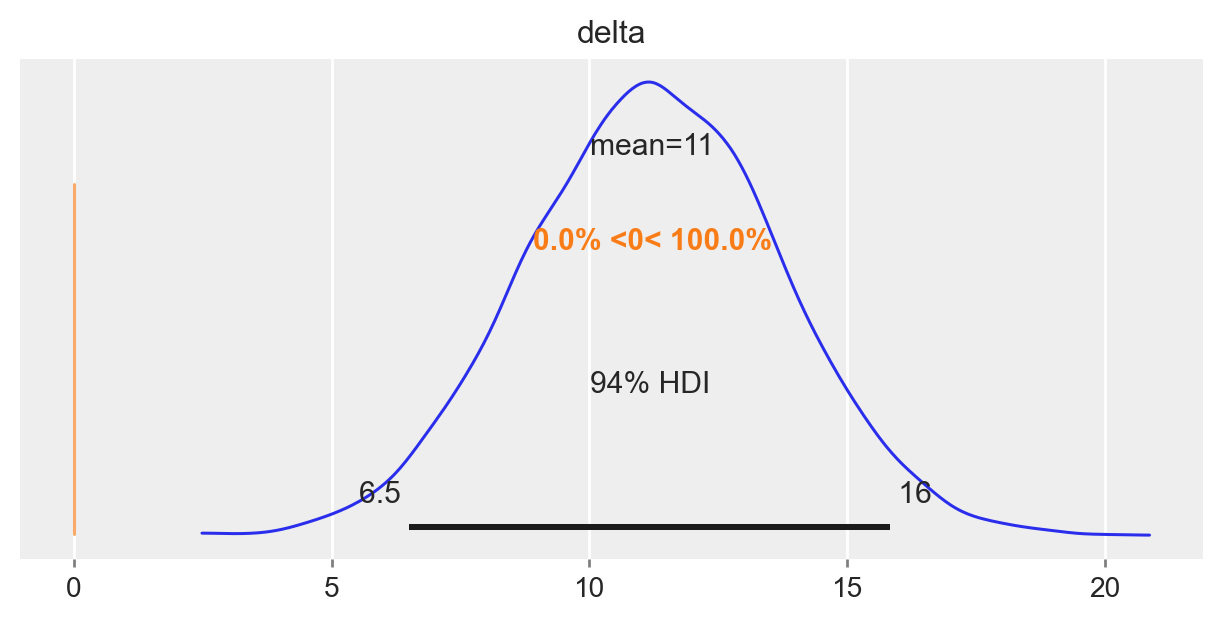

In [19]:
_ = az.plot_posterior(sample_h, var_names="delta", ref_val=0, figsize=(6, 3))

La figura seguente mostra la distribuzione a posteriori della grandezza dell'effetto.

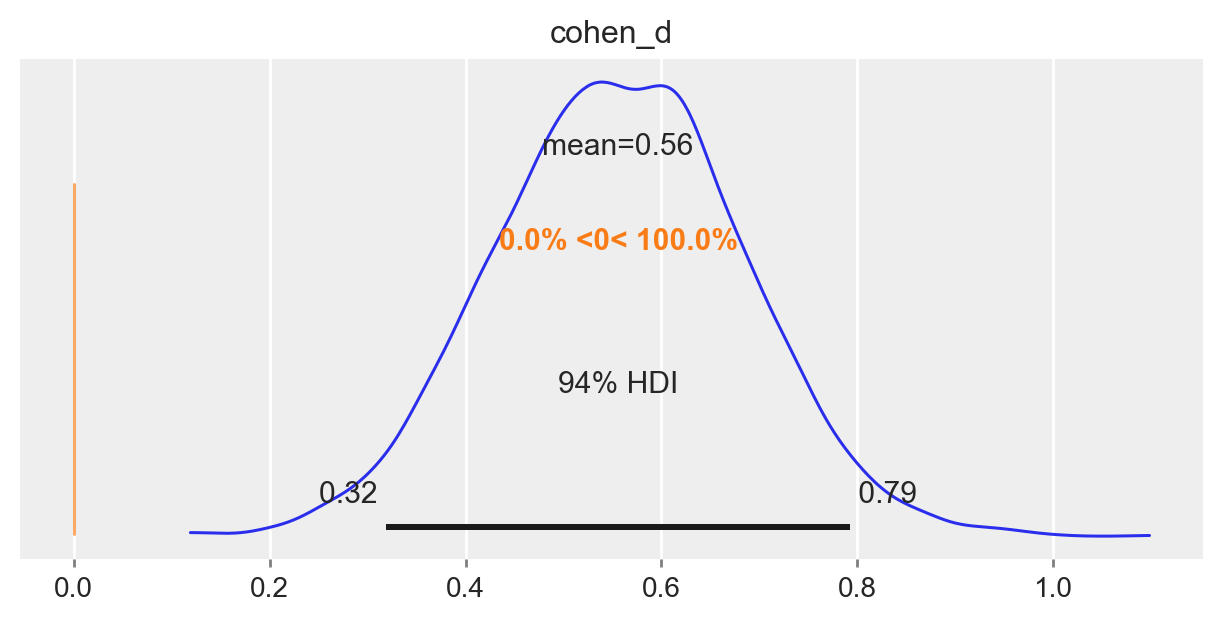

In [20]:
_ = az.plot_posterior(sample_h, var_names="cohen_d", ref_val=0, figsize=(6, 3))

Possiamo dunque concludere che, per ciò che concerne l'effetto della scolarità della madre sul quoziente di intelligenza del bambino, la dimensione dell'effetto è "media".

## Verifica di ipotesi bayesiana

Come ulteriore approfondimento di questa analisi statistica, possiamo esaminare l'approccio bayesiano equivalente al test di ipotesi tradizionale.

Dopo aver ottenuto un campione dalla distribuzione a posteriori del parametro di interesse $\mu$ per ciascun gruppo, possiamo porci la domanda: qual è la probabilità che il QI di un bambino in un gruppo sia maggiore di quello di un bambino nell'altro gruppo? Per rispondere a questa domanda, utilizzeremo campioni casuali dalle distribuzioni a posteriori dei parametri. Confronteremo le coppie di valori campionati dalle due distribuzioni a posteriori del parametro di interesse e calcoleremo la media di tali confronti. Questo ci fornirà un'indicazione sulla probabilità che il QI di un bambino in un gruppo sia maggiore di quello di un bambino nell'altro gruppo, basandoci sulla distribuzione a posteriori dei parametri stimati dal modello.

Per eseguire un test d'ipotesi per calcolare la probabilità che $ \mu_1 > \mu_2 $ utilizzando il modello Stan fornito e cmdstanpy, è necessario estrarre i campioni posteriori per i parametri $\mu_1$ e $\mu_2$ dopo aver adattato il modello. Successivamente, è possibile calcolare la probabilità basandosi sui campioni posteriori. Ad esempio, ci possiamo chiedere quale sia la probabilità che un bambino la cui madre ha completato la scuola superiore abbia un QI maggiore di un bambino la cui madre non ha completato la scuola superiore.

In [21]:
# Extract the posterior samples for mu_1 and mu_2
posterior = sample_h.draws_pd()
posterior['mu_1'] = posterior['mu_2'] + posterior['delta']

# Compute the probability that mu_1 > mu_2
prob_mu1_greater_mu2 = np.mean(posterior['mu_1'] > posterior['mu_2'])

print(f"Probability that mu_1 > mu_2: {prob_mu1_greater_mu2:.4f}")

Probability that mu_1 > mu_2: 1.0000


Una tale probabilità è effettivamente uguale a 1 il che conferma il risultato precedente, ovvero l'iportanza del livello di istruzione della madre per il QI del figlio.

## Commenti e considerazioni finali

In questo capitolo abbiamo esaminato la procedura bayesiana per calcolare la distribuzione a posteriori della differenza tra le medie di due gruppi indipendenti. Inoltre, abbiamo esplorato il calcolo della dimensione dell'effetto in termini bayesiani. Nell'esempio trattato, abbiamo considerato il caso in cui la verosimiglianza è descritta da una distribuzione Gaussiana. Tuttavia, va sottolineato che la scelta di una distribuzione specifica per la verosimiglianza non è vincolante nella statistica bayesiana. È possibile utilizzare qualsiasi distribuzione di probabilità, purché sia adeguata ai dati del campione.

Nel caso del confronto tra le medie di due gruppi indipendenti, una distribuzione molto utilizzata è la distribuzione $t$ di Student. Questa distribuzione è particolarmente vantaggiosa quando si desidera condurre un'analisi statistica "robusta", ovvero un'analisi che non sia influenzata da osservazioni anomale o outlier presenti nei dati. Per questo motivo, la distribuzione $t$ di Student è spesso preferita quando si lavora con dati che potrebbero contenere valori anomali.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [25]:
%load_ext watermark
%watermark -n -u -v -iv -w -m 

Last updated: Sat Jul 27 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

scipy     : 1.14.0
seaborn   : 0.13.2
pandas    : 2.2.2
arviz     : 0.18.0
matplotlib: 3.9.1
numpy     : 1.26.4

Watermark: 2.4.3

